In [36]:
import logging
import numpy as np
import perceval as pcvl
from perceval.algorithm import Sampler
from perceval.components import PS, BS
import sys

from utils import svd_decomposition, print_circuit_structure, build_prcvl_circuit
from clements import decompose_clements
from tools.decomposition import decomposition
from exqalibur import FockState

logging.basicConfig(
    stream=sys.stdout,      # Direct logs to stdout
    level=logging.INFO
)

### INPUT

In [2]:
X = np.array([
    [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
])

### 8x8 -> 6x6

In [3]:
X_att = decomposition(X)

### SVD Decomposition

In [4]:
U, S, Vt = svd_decomposition(X_att)

### Building Circuit with Clement's decomposition

#### For Vt

In [5]:
V_c = decompose_clements(Vt)
[v_phis, v_thetas, v_alphas] = V_c
v_circ = build_prcvl_circuit(v_phis, v_thetas, v_alphas, "Vt", 6)
#pcvl.pdisplay(circ, recursive=True)

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=1.571
  [MZI] connecting WG-2 & WG-3 | phi=3.142, theta=1.571
  [MZI] connecting WG-4 & WG-5 | phi=3.142, theta=0.785
Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=3.142, theta=0.527
  [MZI] connecting WG-3 & WG-4 | phi=1.571, theta=1.571
Layer 2:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=0.000
  [MZI] connecting WG-2 & WG-3 | phi=4.712, theta=0.884
  [MZI] connecting WG-4 & WG-5 | phi=3.142, theta=1.571


#### For Sigma

In [6]:
S_att = S / S[0][0]
S_att

array([[1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.89201339, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.66116847, 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.63587393, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.62988599,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.19456749]])

In [7]:
S_c = decompose_clements(S_att)
[s_phis, s_thetas, s_alphas] = S_c
s_circ = build_prcvl_circuit(s_phis, s_thetas, s_alphas, "S", 6)

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=1.571
  [MZI] connecting WG-2 & WG-3 | phi=3.142, theta=1.571
  [MZI] connecting WG-4 & WG-5 | phi=0.000, theta=1.571
Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=1.571, theta=1.571
  [MZI] connecting WG-3 & WG-4 | phi=3.142, theta=1.571
Layer 2:
  [MZI] connecting WG-0 & WG-1 | phi=0.000, theta=1.571
  [MZI] connecting WG-2 & WG-3 | phi=4.712, theta=1.571
  [MZI] connecting WG-4 & WG-5 | phi=3.142, theta=1.571


#### For U

In [8]:
U_c = decompose_clements(U)
[u_phis, u_thetas, u_alphas] = U_c
u_circ = build_prcvl_circuit(u_phis, u_thetas, u_alphas, "U", 6)

Layer 0:
  [MZI] connecting WG-0 & WG-1 | phi=0.000, theta=0.390
  [MZI] connecting WG-2 & WG-3 | phi=3.142, theta=1.571
  [MZI] connecting WG-4 & WG-5 | phi=3.142, theta=1.571
Layer 1:
  [MZI] connecting WG-1 & WG-2 | phi=4.712, theta=0.000
  [MZI] connecting WG-3 & WG-4 | phi=6.283, theta=0.000
Layer 2:
  [MZI] connecting WG-0 & WG-1 | phi=3.142, theta=1.221
  [MZI] connecting WG-2 & WG-3 | phi=1.571, theta=1.571
  [MZI] connecting WG-4 & WG-5 | phi=3.142, theta=0.785


### Simulation

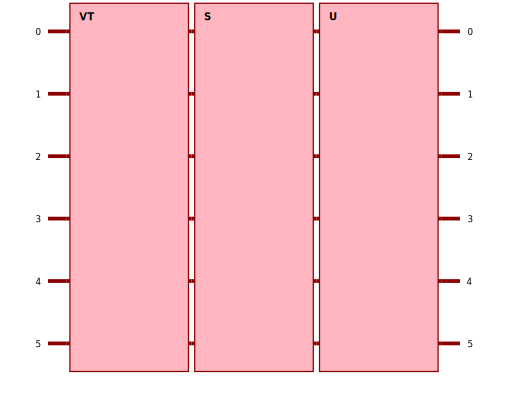

In [9]:
circuit = (pcvl.Circuit(6)
      .add(0, v_circ, merge=False)
      .add(0, s_circ, merge=False)
      .add(0, u_circ, merge=False)
)

pcvl.pdisplay(circuit, recursive=False)

In [10]:
p = pcvl.Processor("SLOS", circuit)
p.min_detected_photons_filter(1)
p.compute_physical_logical_perf(True)

ps = pcvl.PostSelect("[0,1] == 1 & [2,3] == 1 & [4,5] == 1")
p.set_postselection(ps)

p.with_input(pcvl.BasicState([1,0,1,0,1,0]))
sampler = Sampler(p)
probs = sampler.probs()
print(probs['results'])

{
	|1,0,0,1,1,0>: 0.07890482935566066
	|0,1,1,0,1,0>: 0.012455090340283359
	|0,1,0,1,0,1>: 0.01051174514770072
	|0,1,1,0,0,1>: 0.012455090340287822
	|0,1,0,1,1,0>: 0.010511745147704468
	|1,0,1,0,0,1>: 0.3981283351564365
	|1,0,1,0,1,0>: 0.3981283351562939
	|1,0,0,1,0,1>: 0.0789048293556325
}


In [42]:
input_states = np.array([
    [1,0,1,0,1,0],
    [1,0,1,0,0,1],
    [1,0,0,1,1,0],
    [1,0,0,1,0,1],
    [0,1,1,0,1,0],
    [0,1,1,0,0,1],
    [0,1,0,1,1,0],
    [0,1,0,1,0,1],
])
input_states_s = []
data_map={}
for i in input_states:
    s = ",".join(map(str,i.tolist()))
    state = f"|{s}>"
    input_states_s.append(state)
    #print("Input: ", state)
    p.with_input(pcvl.BasicState(i))
    sampler = Sampler(p)
    probs = sampler.probs()
    #print(probs['results'])
    data_map[state] = {}
    for i2 in input_states:
        prob = probs['results'].get(FockState(i2))
        ss = ",".join(map(str,i2.tolist()))
        sstate = f"|{ss}>"
        data_map[state][sstate] = prob
data_map

{'|1,0,1,0,1,0>': {'|1,0,1,0,1,0>': 0.398128335156294,
  '|1,0,1,0,0,1>': 0.3981283351564366,
  '|1,0,0,1,1,0>': 0.07890482935566066,
  '|1,0,0,1,0,1>': 0.07890482935563248,
  '|0,1,1,0,1,0>': 0.012455090340283392,
  '|0,1,1,0,0,1>': 0.012455090340287854,
  '|0,1,0,1,1,0>': 0.010511745147704466,
  '|0,1,0,1,0,1>': 0.010511745147700709},
 '|1,0,1,0,0,1>': {'|1,0,1,0,1,0>': 0.39812833515629065,
  '|1,0,1,0,0,1>': 0.3981283351564337,
  '|1,0,0,1,1,0>': 0.07890482935566358,
  '|1,0,0,1,0,1>': 0.07890482935563516,
  '|0,1,1,0,1,0>': 0.012455090340283286,
  '|0,1,1,0,0,1>': 0.01245509034028776,
  '|0,1,0,1,1,0>': 0.010511745147704863,
  '|0,1,0,1,0,1>': 0.010511745147701071},
 '|1,0,0,1,1,0>': {'|1,0,1,0,1,0>': 0.006000800392180266,
  '|1,0,1,0,0,1>': 0.006000800392182416,
  '|1,0,0,1,1,0>': 0.3961762736322699,
  '|1,0,0,1,0,1>': 0.39617627363212826,
  '|0,1,1,0,1,0>': 0.04504410298091804,
  '|0,1,1,0,0,1>': 0.04504410298093416,
  '|0,1,0,1,1,0>': 0.05277882299470293,
  '|0,1,0,1,0,1>': 0.05

/tmp/ipykernel_7393/3427979365.py:54: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


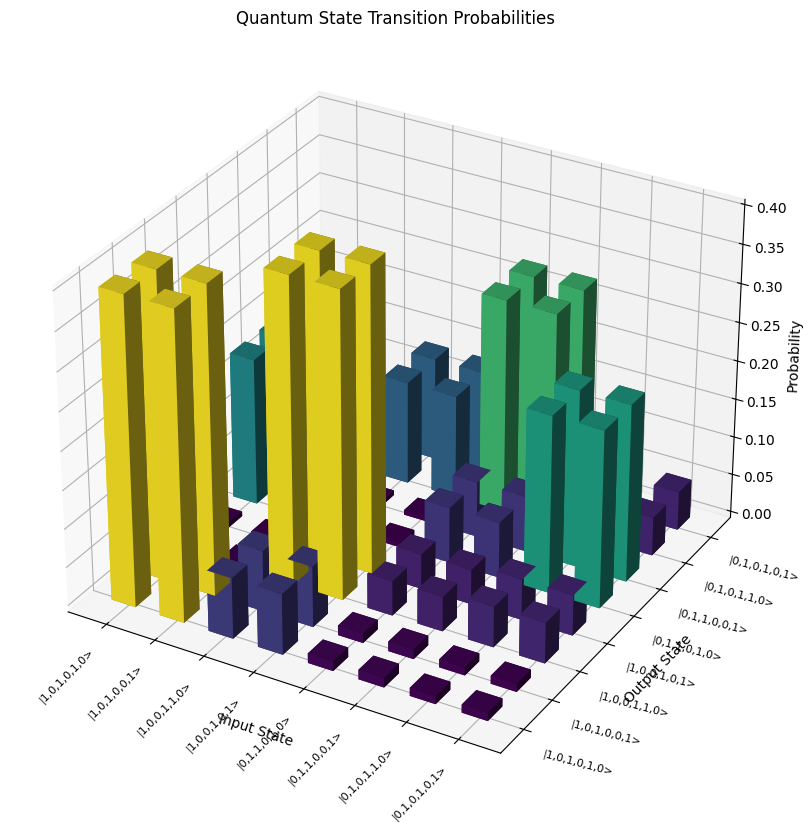

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

labels = input_states_s


z_values = []
for x_label in labels:
    row = []
    for y_label in labels:
        row.append(data_map[x_label][y_label])
    z_values.append(row)

z_values = np.array(z_values)

# 3. Setup the 3D Plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Create a meshgrid for the X and Y positions
_x = np.arange(len(labels))
_y = np.arange(len(labels))
_xx, _yy = np.meshgrid(_x, _y)

# Flatten arrays for bar3d input
x, y = _xx.ravel(), _yy.ravel()
top = z_values.ravel()  # The height of the bars
bottom = np.zeros_like(top) # Bars start at 0
width = depth = 0.5

# Color the bars based on height
cmap = plt.cm.viridis
norm = plt.Normalize(top.min(), top.max())
colors = cmap(norm(top))

# Plot
ax.bar3d(x, y, bottom, width, depth, top, shade=True, color=colors)

# 4. Formatting Axes
# Position ticks in the center of the bars
ax.set_xticks(np.arange(len(labels)) + 0.25) 
ax.set_yticks(np.arange(len(labels)) + 0.25)

# Set the text labels
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
ax.set_yticklabels(labels, rotation=-15, ha='left', fontsize=8)

ax.set_xlabel('Input State')
ax.set_ylabel('Output State')
ax.set_zlabel('Probability')
ax.set_title('Quantum State Transition Probabilities')

plt.tight_layout()
plt.show()
